In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import OrderedDict

energy = 10 # np.random.uniform(-1, 1) 
imag = 0.1j
N=25
x_, y_, z_ = np.random.randint(N, size=3)
print("Saving to file", 'greenfs-{}-{}-{}.pickle'.format(x_, y_, z_))

mapping, inv_mapping = [], []

import sys

# class Logger(object):
#     def __init__(self):
#         self.terminal = sys.stdout
#         self.log = open("log.dat", "a")

#     def write(self, message):
#         self.terminal.write(message)
#         self.log.write(message)  

# sys.stdout = Logger()

def generate_triples(N, total):
    # List containing generated triples
    gen = []

    
    if 0 <= total <= N - 1:
        # Generate first element
        i, j, k = (0, 0, total)
        while i <= total:
            # print ("now i is", i)
            while j <= total - i:
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            j = 0
            k = total - i
            
                # pass

    elif N <= total <= 2*N - 3:
        # Generate first element
        i, j, k = (0, total-N+1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k


            
    elif 2*N - 2 <= total <= 3*N - 3:
        # Generate first element
        i, j, k = (total - 2*N + 2, N-1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k
        
    else:
        raise ValueError("Not applicable k")

    return gen

def index_triple_maps(N):
    mapping = {}
    inv_mapping = {}
    for k in range(3*N - 2):
        triples = generate_triples(N, k)
        coords = OrderedDict()
        inv_coords = OrderedDict()
        for i in range(len(triples)):
            coords[i] = triples[i]
            inv_coords[triples[i]] = i
        mapping[k] = coords
        inv_mapping[k] = inv_coords
    return mapping, inv_mapping

def omit_sites(inv_mapping, omit):
    print ("Omitting", (omit).shape[0] - np.sum(omit), "sites")    
    site = 0
    new_inv_map = {}
    new_map = {}
    
    for sum_ in inv_mapping.keys():
        inv_sum_k_sites = OrderedDict()
        sum_k_sites = OrderedDict()
        site_index = 0
        for triple in inv_mapping[sum_].keys():
            if omit[site] == 1:
                inv_sum_k_sites[triple] = site_index
                sum_k_sites[site_index] = triple
                site_index += 1
            else:
                x, y, z = triple
                # print ("I'm omitting", triple)
            site += 1
        new_inv_map[sum_] = inv_sum_k_sites
        new_map[sum_] = sum_k_sites

    return new_map, new_inv_map, x, y, z

def _calculate(z_n, x_, y_, z_, x_o, y_o, z_o, t_n = 1.0, e_n = 1.0, N = 20, k = 1, c = complex,
                           mapping = mapping, inv_mapping = inv_mapping):

    

    amplitude = t_n / (z_n - e_n)
    # amplitude = 1
    a = {}
    b = {}

    # tic = time.time()
    for k in range(3*N-2):
        alpha_num_entries = len(inv_mapping[k-1]) if k > 0 else 0
        my_entries = len(inv_mapping[k])
        beta_num_entries = len(inv_mapping[k+1]) if k < 3*N - 3 else 0
        a_k = np.zeros((my_entries, alpha_num_entries), dtype=c)
        b_k = np.zeros((my_entries, beta_num_entries), dtype=c)
        for index, triple in mapping[k].items():
            x, y, z = triple

            # Calculate b_k
            if k < 3*N - 3:
                if x < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x + 1, y, z]] = amplitude
                    except:
                        pass
                    
                if y < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y + 1, z]] = amplitude
                    except:
                        pass

                if z < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y, z + 1]] = amplitude
                    except:
                        pass
#             # Calculate a_k
            if 0 < k:
                if x > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x - 1, y, z]] = amplitude
                    except:
                        pass

                if y > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y - 1, z]] = amplitude
                    except:
                        pass

                if z > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y, z - 1]] = amplitude
                    except:
                        pass

        a[k] = a_k
        b[k] = b_k
    # toc = time.time()
    # print ("Time building a, b matrices", toc - tic)

    # Calculate C
    sum_ = sum([x_, y_, z_])
    
    C = np.zeros(shape = (len(inv_mapping[sum_]), 1), dtype = complex)
    C[inv_mapping[sum_][(x_, y_, z_)]] = 1. / (z_n - e_n)
    
        



    # Calculate Multiplicative Factors 
    A = {}
    G = {}
    A[1] = b[1]
    tic = time.time()
    for k in range(2, sum_):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), b[k])


    A[3*N - 4] = a[3*N - 4]
    for k in range(3*N - 5, sum_, -1):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), a[k])

    
    # Calculate Green's Functions
    V = OrderedDict()
    k = sum_
    if 1 < k < 3*N-4:
        V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]) - b[k].dot(A[k + 1]), 
                            C)
    elif k == 1:
        V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), 
                            C)
    elif k == 3*N - 4:
        V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), 
                            C)
            
    
    # if x_t + y_t + z_t > sum_:
    for k in range(sum_ + 1, 3*N - 3):
        V[k] = A[k].dot(V[k - 1])
    # elif x_t + y_t + z_t < sum_:
    for k in range(sum_ - 1, 0, -1):
        V[k] = A[k].dot(V[k + 1])

    # return V[x_t + y_t + z_t]
    toc = time.time()
    print ("Time doing lin alg", toc - tic)
    return V



Saving to file greenfs-15-11-4.pickle


In [2]:

mapping, inv_mapping = index_triple_maps(N)
true_value = (_calculate(energy+imag, x_, y_, z_, 1, 1, 1, mapping = mapping, inv_mapping = inv_mapping))
true_value = true_value[sum([x_, y_, z_])][inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
greenfs = OrderedDict()  
greenfs["true_value"] = true_value
threshold = 0.01


Time doing lin alg 3.5906319618225098


In [3]:

from collections import OrderedDict

omit = np.full(N**3, 1)

ind = np.arange(N**3)
batches = OrderedDict()
batches[tuple(ind)] = 0

minibatch_size = 300
tic = time.time()
while minibatch_size >= 1:
    # if minibatch_size < 10:
    #     threshold = 0.02
    # elif minibatch_size < 3:
    #     threshold = 0.01
    new_batches = OrderedDict()
    print ([(len(batch), status) for batch, status in batches.items()])
    print ("minibatch_size", minibatch_size)
    for batch, status in batches.items():
        if status == 0:
            dropping = len(batch) // minibatch_size
            
            minibatches = np.array_split(batch, dropping)
            print ("dropping", dropping)
    #         print(np.array_split(batch, dropping))

            for minibatch in minibatches[::-1]:
                
                print ("len(minibatch)", len(minibatch))
                omit[(minibatch)] = 0
                _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)

                if ((x_, y_, z_) not in _inv_mapping[sum([x_ + y_ + z_])]):
                    omit[(minibatch)] = 1
                    new_batches[tuple(minibatch)] = 0
                    continue
                if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
                    continue

                predicted_value = (_calculate(energy+imag, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
                predicted_value = predicted_value[sum([x_, y_, z_])][_inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]

                rel_err = np.absolute(predicted_value - true_value) / np.absolute(true_value)
                if rel_err > threshold:
                    omit[(minibatch)] = 1
                    print ("Error", rel_err, "over threshold!", threshold)
                    new_batches[tuple(minibatch)] = 0
                else:
                    new_batches[tuple(minibatch)] = 1
                print ("true_value", true_value)
                print ("predicted_value", predicted_value)

        elif status == 1:
            new_batches[tuple(batch)] = 1
            omit[list(batch)] = 0
    
    minibatch_size = minibatch_size / 4
    if 1 < minibatch_size < 2:
        minibatch_size = 1
    batches = new_batches
toc = time.time()
print("Calculation took", toc-tic)
        
        

[(15625, 0)]
minibatch_size 300
dropping 52
len(minibatch) 300
Omitting 300 sites
Time doing lin alg 4.039048910140991
true_value [0.12140224-0.00164266j]
predicted_value [0.12140224-0.00164266j]
len(minibatch) 300
Omitting 600 sites
Time doing lin alg 1.8868560791015625
true_value [0.12140224-0.00164266j]
predicted_value [0.12140224-0.00164266j]
len(minibatch) 300
Omitting 900 sites
Time doing lin alg 0.932265043258667
true_value [0.12140224-0.00164266j]
predicted_value [0.12140224-0.00164266j]
len(minibatch) 300
Omitting 1200 sites
Time doing lin alg 0.8634710311889648
true_value [0.12140224-0.00164266j]
predicted_value [0.12140224-0.00164266j]
len(minibatch) 300
Omitting 1500 sites
Time doing lin alg 0.9675872325897217
true_value [0.12140224-0.00164266j]
predicted_value [0.12140224-0.00164266j]
len(minibatch) 300
Omitting 1800 sites
Time doing lin alg 1.0765118598937988
true_value [0.12140224-0.00164266j]
predicted_value [0.12140224-0.00164266j]
len(minibatch) 300
Omitting 2100 site

Time doing lin alg 0.018153905868530273
true_value [0.12140224-0.00164266j]
predicted_value [0.12052015-0.00158024j]
len(minibatch) 75
Omitting 15098 sites
Time doing lin alg 0.015492916107177734
true_value [0.12140224-0.00164266j]
predicted_value [0.12052015-0.00158024j]
len(minibatch) 75
Omitting 15173 sites
Time doing lin alg 0.013145923614501953
true_value [0.12140224-0.00164266j]
predicted_value [0.12033584-0.0015686j]
len(minibatch) 76
Omitting 15249 sites
dropping 4.0
len(minibatch) 75
Omitting 15248 sites
Time doing lin alg 0.005567073822021484
Error [0.04910809] over threshold! 0.01
true_value [0.12140224-0.00164266j]
predicted_value [0.11544543-0.00138504j]
len(minibatch) 75
Omitting 15248 sites
Time doing lin alg 0.004902362823486328
true_value [0.12140224-0.00164266j]
predicted_value [0.12033298-0.00156834j]
len(minibatch) 75
Omitting 15323 sites
Time doing lin alg 0.003715991973876953
true_value [0.12140224-0.00164266j]
predicted_value [0.12033298-0.00156834j]
len(minibatc

Time doing lin alg 0.001544952392578125
true_value [0.12140224-0.00164266j]
predicted_value [0.12022821-0.00156143j]
len(minibatch) 1
Omitting 15607 sites
Time doing lin alg 0.0013418197631835938
Error [0.01039704] over threshold! 0.01
true_value [0.12140224-0.00164266j]
predicted_value [0.12014287-0.00155622j]
len(minibatch) 1
Omitting 15607 sites
Time doing lin alg 0.0015311241149902344
Error [0.01038835] over threshold! 0.01
true_value [0.12140224-0.00164266j]
predicted_value [0.12014392-0.00155631j]
len(minibatch) 1
Omitting 15607 sites
Time doing lin alg 0.002042055130004883
true_value [0.12140224-0.00164266j]
predicted_value [0.1202282-0.00156143j]
len(minibatch) 1
Omitting 15608 sites
Time doing lin alg 0.0011072158813476562
true_value [0.12140224-0.00164266j]
predicted_value [0.1202282-0.00156143j]
dropping 5
len(minibatch) 1
Omitting 15609 sites
Time doing lin alg 0.0018961429595947266
true_value [0.12140224-0.00164266j]
predicted_value [0.1202282-0.00156143j]
len(minibatch) 1

In [47]:
def gen_triples(N):
    i, j, k = (0, 0, 0)
    coords = []
    for i in range(N):
        for j in range(N):
            for k in range(N):
                coords.append((i,j,k))

    return coords


coords = gen_triples(N)
state_mapping = {i: coords[i] for i in range(len(coords))}
inv_state_mapping = {coords[i]: i for i in range(len(coords))}

# for state in np.where(omit)[0]:
#     omit = np.full(N**3, 1)
#     omit[state] = 0
#     _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
#     print(x_o, y_o, z_o)
    

Omitting 1 sites
10 16 13
Omitting 1 sites
11 15 13
Omitting 1 sites
11 16 12
Omitting 1 sites
11 15 14
Omitting 1 sites
11 16 13
Omitting 1 sites
11 17 12
Omitting 1 sites
12 15 13
Omitting 1 sites
11 16 14
Omitting 1 sites
11 17 13
Omitting 1 sites
12 16 13


In [108]:
imaginary = 0.1j
real_pred, imagin_pred = [], []
real_true, imagin_true = [], []
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
for z in np.linspace(0, 10, 100):
    true_value = (_calculate(z+imaginary, x_, y_, z_, x_o, y_o, z_o, mapping = mapping, inv_mapping = inv_mapping))
    true_value = true_value[sum([x_, y_, z_])][inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
    real_true.append(np.real(true_value))
    imagin_true.append(np.imag(true_value))
    predicted_value = (_calculate(z+imaginary, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
    predicted_value = predicted_value[sum([x_, y_, z_])][_inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
    real_pred.append(np.real(predicted_value))
    imagin_pred.append(np.imag(predicted_value))

imaginary = 0.01j
real_pred_001, imagin_pred_001 = [], []
real_true_001, imagin_true_001 = [], []
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
for z in np.linspace(0, 10, 100):
    true_value = (_calculate(z+imaginary, x_, y_, z_, x_o, y_o, z_o, mapping = mapping, inv_mapping = inv_mapping))
    true_value = true_value[sum([x_, y_, z_])][inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
    real_true_001.append(np.real(true_value))
    imagin_true_001.append(np.imag(true_value))
    predicted_value = (_calculate(z+imaginary, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
    predicted_value = predicted_value[sum([x_, y_, z_])][_inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
    real_pred_001.append(np.real(predicted_value))
    imagin_pred_001.append(np.imag(predicted_value))
    
imaginary = 0.001j
real_pred_0001, imagin_pred_0001 = [], []
real_true_0001, imagin_true_0001 = [], []
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
for z in np.linspace(0, 10, 100):
    true_value = (_calculate(z+imaginary, x_, y_, z_, x_o, y_o, z_o, mapping = mapping, inv_mapping = inv_mapping))
    true_value = true_value[sum([x_, y_, z_])][inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
    real_true_0001.append(np.real(true_value))
    imagin_true_0001.append(np.imag(true_value))
    predicted_value = (_calculate(z+imaginary, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
    predicted_value = predicted_value[sum([x_, y_, z_])][_inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
    real_pred_0001.append(np.real(predicted_value))
    imagin_pred_0001.append(np.imag(predicted_value))



Omitting 15620 sites
Time doing lin alg 1.2524480819702148
Time doing lin alg 0.0010509490966796875
Time doing lin alg 1.0395021438598633
Time doing lin alg 0.0012831687927246094
Time doing lin alg 0.912438154220581
Time doing lin alg 0.0010292530059814453
Time doing lin alg 0.9226949214935303
Time doing lin alg 0.0012240409851074219
Time doing lin alg 0.9111108779907227
Time doing lin alg 0.0011370182037353516
Time doing lin alg 0.9264490604400635
Time doing lin alg 0.0010800361633300781
Time doing lin alg 1.0404510498046875
Time doing lin alg 0.0012619495391845703
Time doing lin alg 1.1697978973388672
Time doing lin alg 0.0010461807250976562
Time doing lin alg 1.3640100955963135
Time doing lin alg 0.0014050006866455078
Time doing lin alg 0.9997260570526123
Time doing lin alg 0.002691030502319336
Time doing lin alg 1.2322561740875244
Time doing lin alg 0.0023550987243652344
Time doing lin alg 0.8499341011047363
Time doing lin alg 0.0010139942169189453
Time doing lin alg 0.871583938598

Time doing lin alg 1.1622340679168701
Time doing lin alg 0.002009153366088867
Time doing lin alg 1.965660810470581
Time doing lin alg 0.0039038658142089844
Time doing lin alg 1.4437108039855957
Time doing lin alg 0.0010480880737304688
Time doing lin alg 1.2043819427490234
Time doing lin alg 0.0010631084442138672
Time doing lin alg 1.8784098625183105
Time doing lin alg 0.0014531612396240234
Time doing lin alg 1.1155860424041748
Time doing lin alg 0.001093149185180664
Time doing lin alg 1.4893901348114014
Time doing lin alg 0.0012471675872802734
Time doing lin alg 1.2314848899841309
Time doing lin alg 0.003464937210083008
Time doing lin alg 0.9664421081542969
Time doing lin alg 0.0011148452758789062
Time doing lin alg 1.103684902191162
Time doing lin alg 0.0010509490966796875
Time doing lin alg 1.0667200088500977
Time doing lin alg 0.0014183521270751953
Time doing lin alg 0.9488589763641357
Time doing lin alg 0.0017468929290771484
Time doing lin alg 0.9864501953125
Time doing lin alg 0.0

Time doing lin alg 0.9304499626159668
Time doing lin alg 0.0010690689086914062
Time doing lin alg 0.8944759368896484
Time doing lin alg 0.0010759830474853516
Time doing lin alg 0.8867640495300293
Time doing lin alg 0.0010943412780761719
Time doing lin alg 0.9279239177703857
Time doing lin alg 0.001065969467163086
Time doing lin alg 0.8973309993743896
Time doing lin alg 0.0010161399841308594
Time doing lin alg 0.931635856628418
Time doing lin alg 0.0012280941009521484
Time doing lin alg 0.9164950847625732
Time doing lin alg 0.0012691020965576172
Time doing lin alg 0.8973302841186523
Time doing lin alg 0.0013248920440673828
Time doing lin alg 0.8713452816009521
Time doing lin alg 0.0013580322265625
Time doing lin alg 0.8865981101989746
Time doing lin alg 0.0010230541229248047
Time doing lin alg 1.0418188571929932
Time doing lin alg 0.0014200210571289062
Time doing lin alg 0.9120161533355713
Time doing lin alg 0.0010838508605957031
Time doing lin alg 0.9113759994506836
Time doing lin alg 

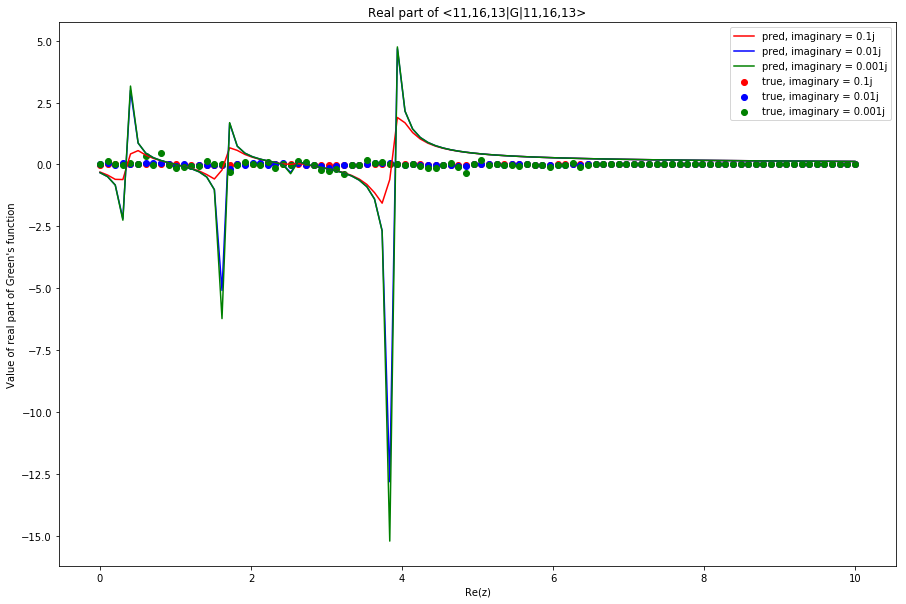

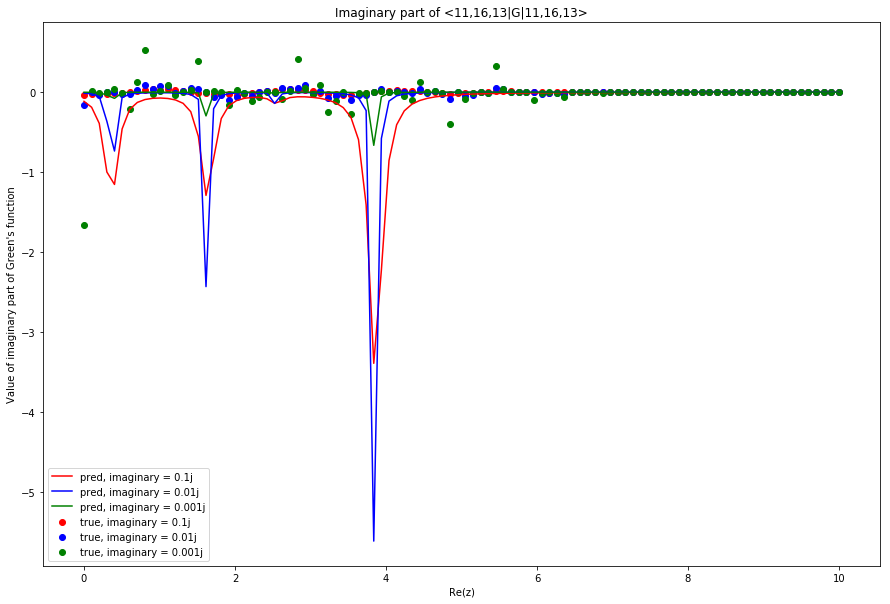

In [78]:
plt.figure(figsize=(15,10))
plt.title("Real part of <11,16,13|G|11,16,13>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j", color="red")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j", color="blue")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j", color="green")
plt.scatter(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j", color="red")
plt.scatter(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j", color="blue")
plt.scatter(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j", color="green")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <11,16,13|G|11,16,13>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j", color="red")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j", color="blue")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j", color="green")
plt.scatter(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j", color="red")
plt.scatter(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j", color="blue")
plt.scatter(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j", color="green")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()


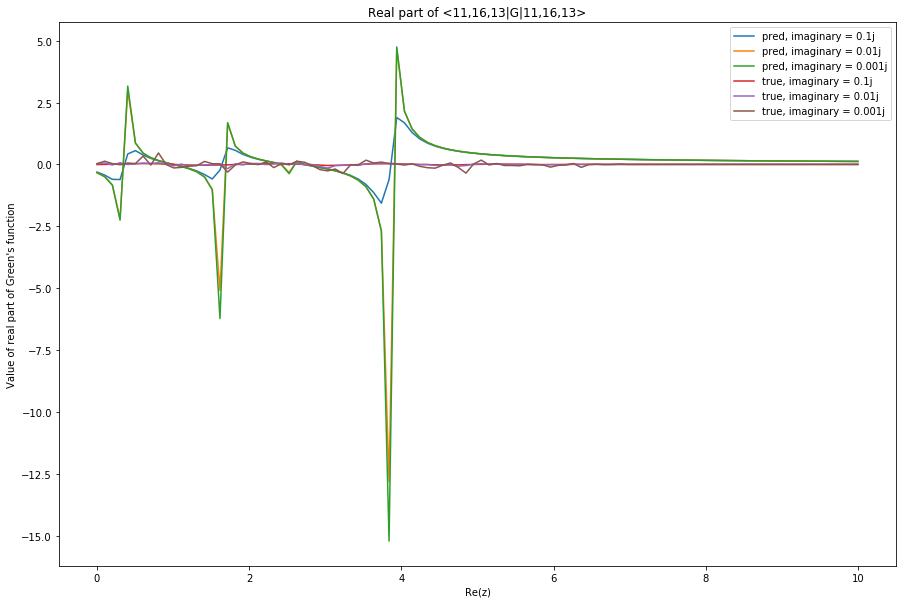

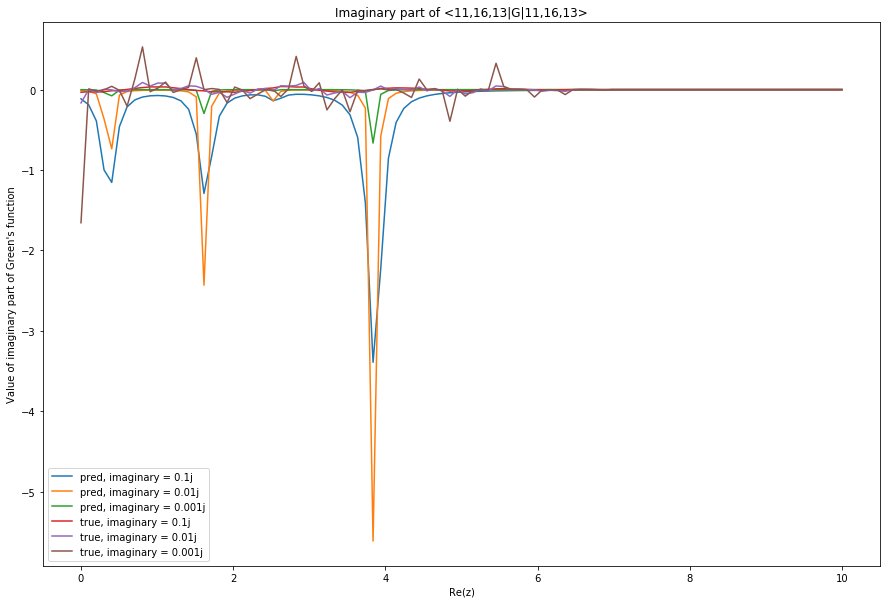

In [80]:
plt.figure(figsize=(15,10))
plt.title("Real part of <11,16,13|G|11,16,13>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <11,16,13|G|11,16,13>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()


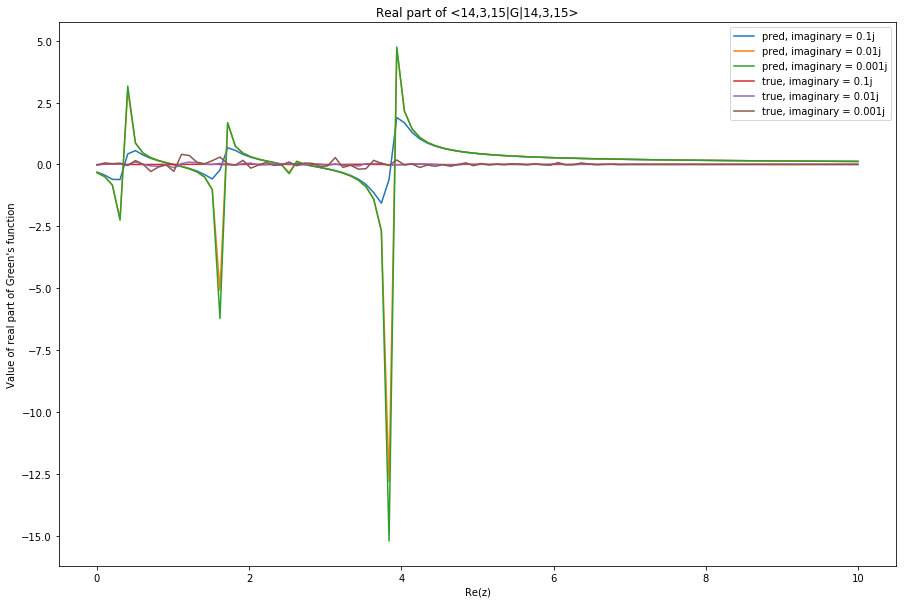

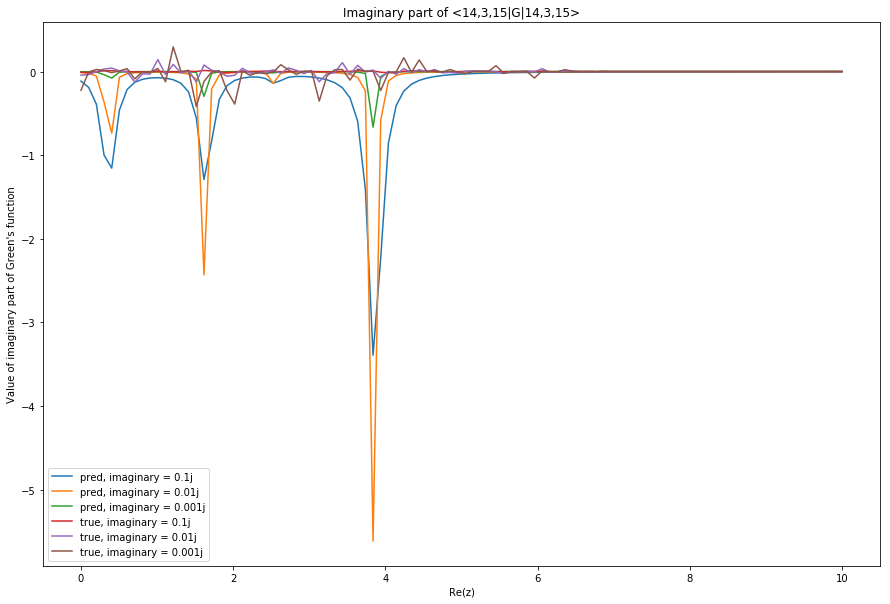

In [86]:
plt.figure(figsize=(15,10))
plt.title("Real part of <14,3,15|G|14,3,15>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <14,3,15|G|14,3,15>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()


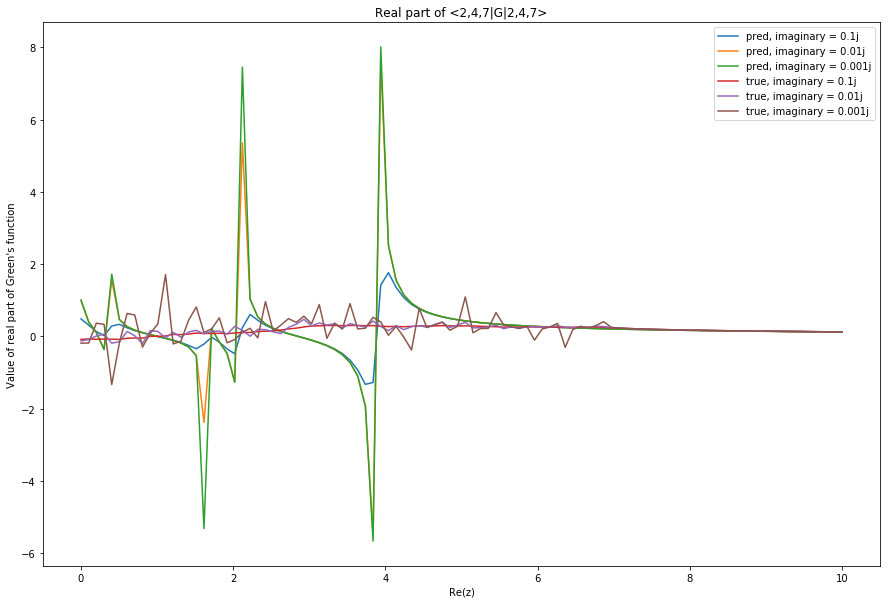

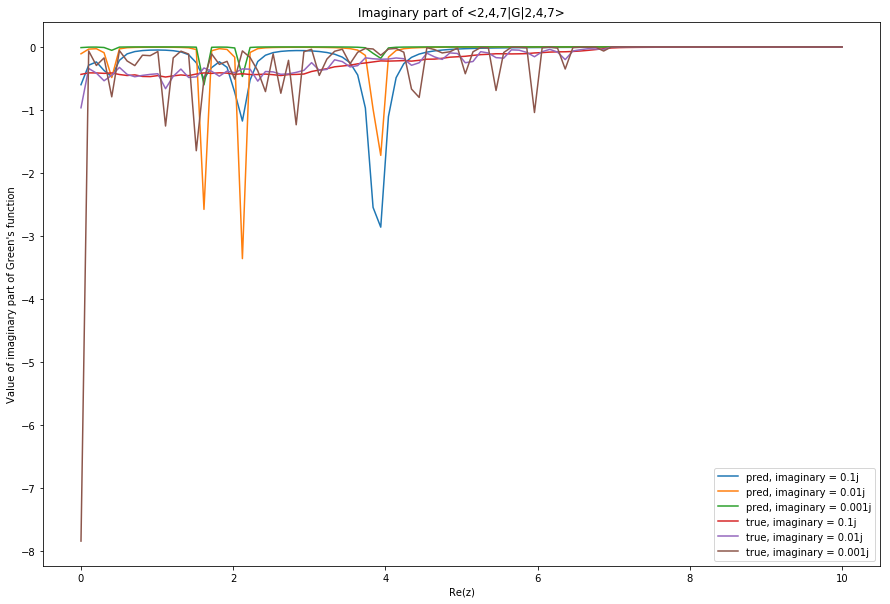

In [94]:
plt.figure(figsize=(15,10))
plt.title("Real part of <2,4,7|G|2,4,7>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <2,4,7|G|2,4,7>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()


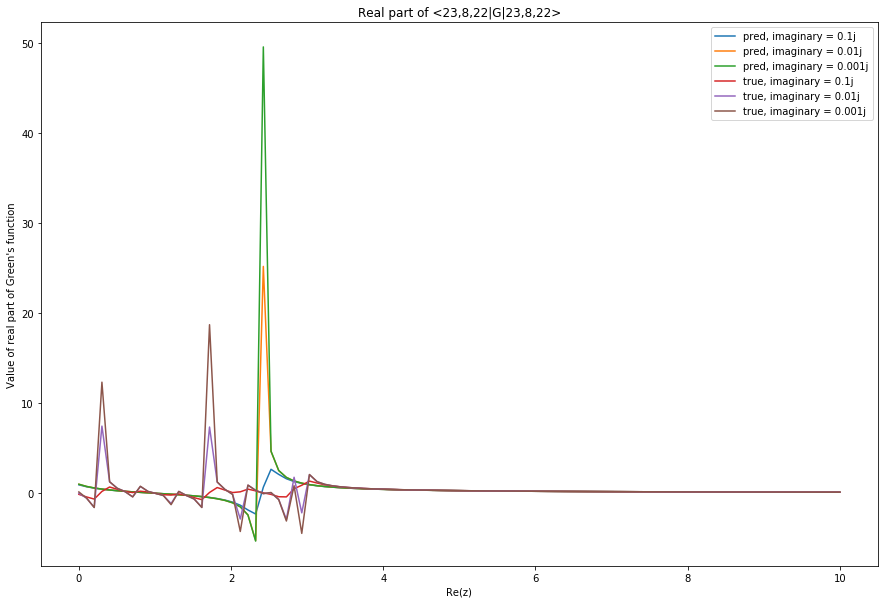

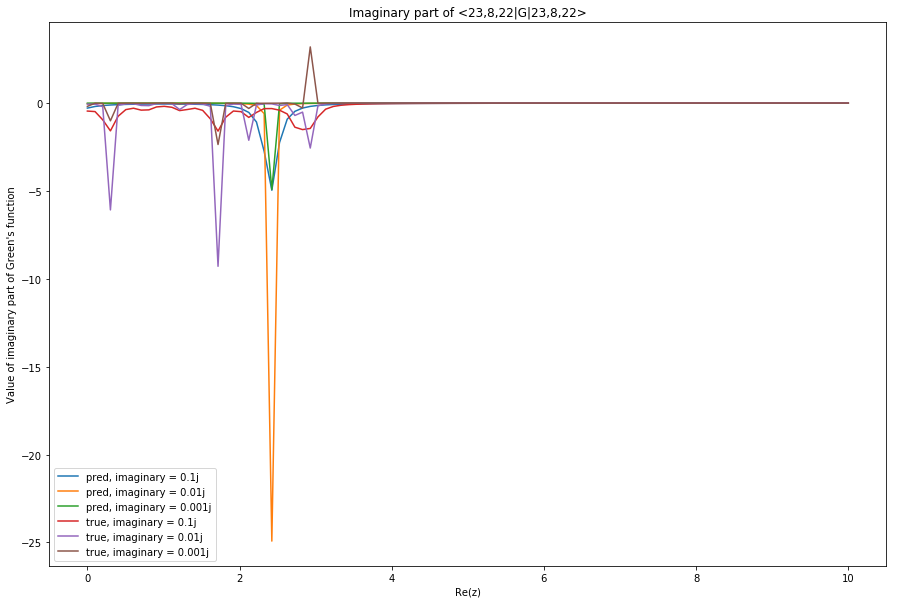

In [99]:
plt.figure(figsize=(15,10))
plt.title("Real part of <23,8,22|G|23,8,22>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <23,8,22|G|23,8,22>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()


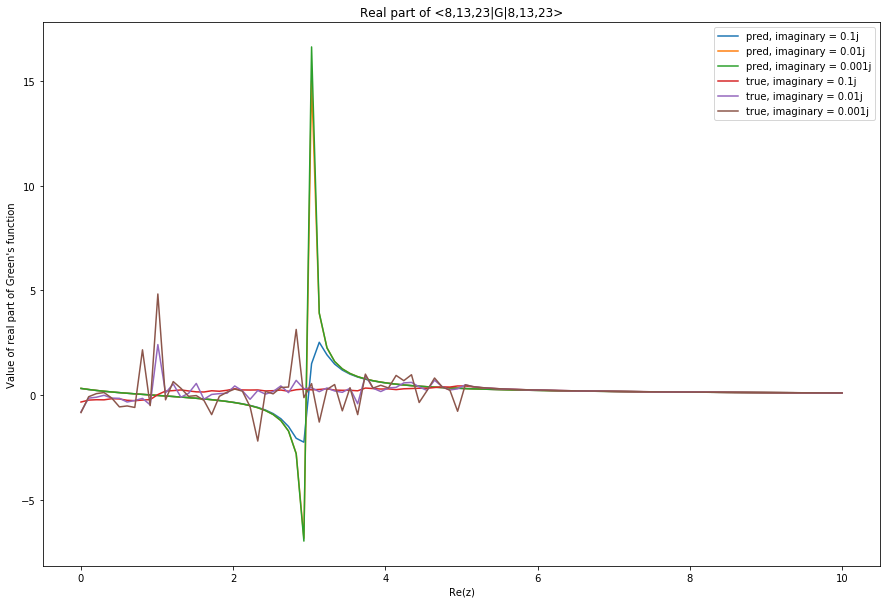

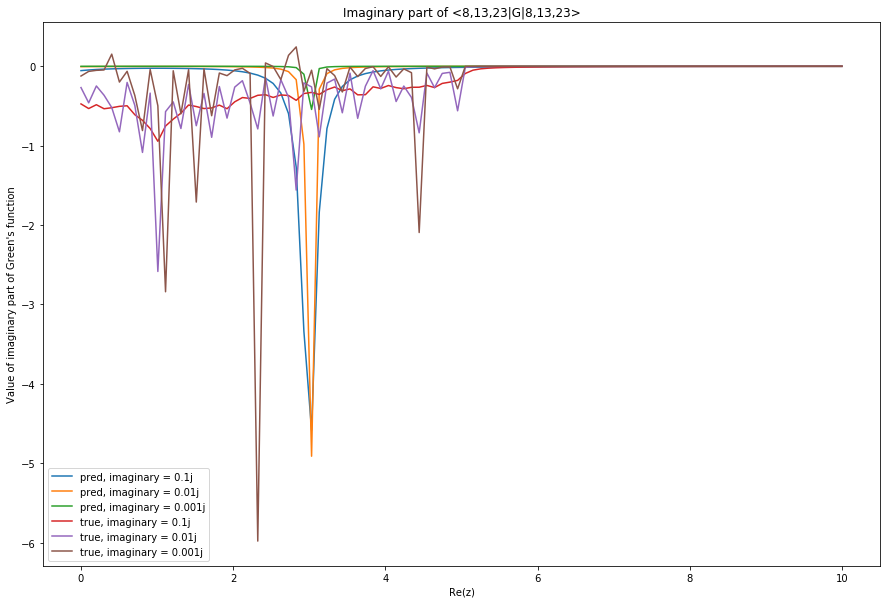

In [104]:
plt.figure(figsize=(15,10))
plt.title("Real part of <8,13,23|G|8,13,23>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <8,13,23|G|8,13,23>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()


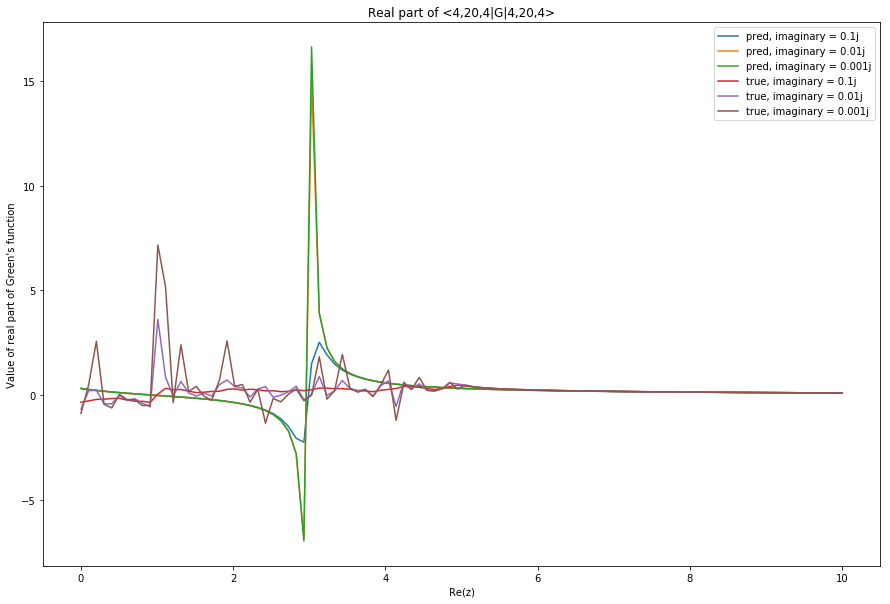

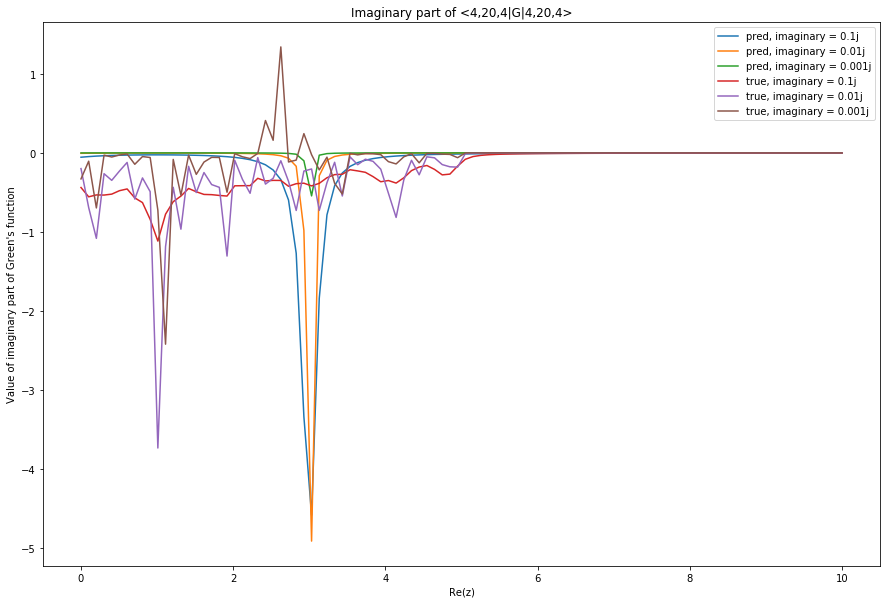

In [109]:
plt.figure(figsize=(15,10))
plt.title("Real part of <4,20,4|G|4,20,4>")
plt.plot(np.linspace(0, 10, 100), real_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), real_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), real_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), real_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of real part of Green's function")
plt.legend()
plt.show()
plt.figure(figsize=(15,10))
plt.title("Imaginary part of <4,20,4|G|4,20,4>")
plt.plot(np.linspace(0, 10, 100), imagin_pred, label="pred, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_001, label="pred, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_pred_0001, label="pred, imaginary = 0.001j")
plt.plot(np.linspace(0, 10, 100), imagin_true, label="true, imaginary = 0.1j")
plt.plot(np.linspace(0, 10, 100), imagin_true_001, label="true, imaginary = 0.01j")
plt.plot(np.linspace(0, 10, 100), imagin_true_0001, label="true, imaginary = 0.001j")
plt.xlabel("Re(z)")
plt.ylabel("Value of imaginary part of Green's function")
plt.legend()
plt.show()
